# Inverse participation ratio (IPR)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from Auxiliary_functions import *
import itertools
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# FUNCTION DEFINITION:

def Correlation_matrix(mapping_products, pr_layers):
    combinations_list = list(itertools.combinations(mapping_products.index, 2))

    combinations_list

    corr_matrix =  pd.DataFrame(np.zeros([len(mapping_products),len(mapping_products)]),index=mapping_products.index,columns=mapping_products.index)
    for pair in combinations_list:
    #pearson correlation between time series 
        pr1 = pr_layers.loc[pr_layers.L1_foodex==pair[0],:].sort_values(by='year').reset_index(drop=True)
        pr2 = pr_layers.loc[pr_layers.L1_foodex==pair[1],:].sort_values(by='year').reset_index(drop=True)
    # pearson correlation with p value
    #corr, p_value = spearmanr(pr1.IPR, pr2.IPR)
        corr, p_value = pearsonr(pr1.IPR, pr2.IPR)
        if p_value<0.050:
            corr_matrix.loc[pair[0],pair[1]]=corr

    corr_matrix[corr_matrix<0]=0
    dissimilarity = 1 - abs(corr_matrix)
    return corr_matrix, dissimilarity

def PageRank_multilayer_no_empty(data_trade_all,year_list, unit, direction='exports',coupling_weight=1): 
    data_trade_all = data_trade_all.copy()
    # Country and product list
    av_countries=set(data_trade_all.destin_country_ISO.unique()).union(set(data_trade_all.origin_country_ISO.unique()))
    av_countries=sorted([*av_countries])    
    #  Change names to include item code 
    data_trade_all.destin_country_ISO=data_trade_all.item_code.astype(str)+'_'+data_trade_all.destin_country_ISO
    data_trade_all.origin_country_ISO=data_trade_all.item_code.astype(str)+'_'+data_trade_all.origin_country_ISO
    
    # Find eigenvector centrality for every year
    dict_years=dict()
    for year in year_list:
        # Filter trade data to specific year:
        data_trade= data_trade_all.loc[(data_trade_all.unit==unit)& (data_trade_all.year==year),:].reset_index(drop=True)
        data_trade=data_trade.drop(columns=['unit','year','origin_country','destin_country','L1_foodex','Food_group','item'])
        
        av_products=data_trade.item_code.sort_values(ascending=True).unique().astype(str)
        # Make coupling dataframe
        coupling_links = [(f"{product2}_{c}" ,f"{product}_{c}") for c in av_countries for product2 in av_products for product in av_products if product2!=product]
        coupling_links = pd.DataFrame(coupling_links,columns=['origin_country_ISO','destin_country_ISO'])
        coupling_links['item_code']=np.nan # we don't care it won't be used 
        coupling_links['value']=coupling_weight 

        # add coupling nodes 
        all_df= pd.concat([data_trade, coupling_links],ignore_index=True)

        # Create NetworkX graph 
        if direction=='exports':
            G=nx.from_pandas_edgelist(all_df, source='destin_country_ISO', target='origin_country_ISO', edge_attr='value', create_using=nx.DiGraph)
        else:
            G=nx.from_pandas_edgelist(all_df, source='origin_country_ISO', target='destin_country_ISO', edge_attr='value', create_using=nx.DiGraph)

        # Get pagerank centrality 
        page_rank = nx.pagerank(G,weight='value',alpha=0.85)
        page_rank_cent= pd.DataFrame({'country_code':page_rank.keys(),
                                    'page_rank':page_rank.values()})
        page_rank_cent['item_code']=page_rank_cent.country_code.str.split('_').str[0]
        dict_years[year]=page_rank_cent

    return(dict_years)        


def PageRank_multilayer(data_trade_all,year_list, unit, prod_agg, direction,coupling_weight,alpha): 
    if prod_agg=='Food_group':
        agg_level = 'L1_foodex'
        remove_cols = ['Food_group','L1_foodex']
        save_folder = 'page_rank_weights_group'
    elif prod_agg=='item_code':
        agg_level = 'item_code'
        remove_cols = ['L1_foodex','Food_group','item','item_code']
        save_folder = 'page_rank_weights_item'
    else: 
        print('Invalid aggregation level')

    if unit=='tonnes':
        unit_save='tonnes'
    else:
        unit_save='doll'
    print('parameters:', direction, unit_save, coupling_weight, alpha)
    # Country and product list
    data_trade_all = data_trade_all.copy()
    av_countries=set(data_trade_all.destin_country_ISO.unique()).union(set(data_trade_all.origin_country_ISO.unique()))
    av_countries=sorted([*av_countries])

    av_products=data_trade_all[agg_level].sort_values(ascending=True).unique().astype(str)
    
    #  Change names to include item code 
    data_trade_all.destin_country_ISO=data_trade_all[agg_level].astype(str)+'_'+data_trade_all.destin_country_ISO
    data_trade_all.origin_country_ISO=data_trade_all[agg_level].astype(str)+'_'+data_trade_all.origin_country_ISO
    
    # Make coupling dataframe
    coupling_links = [(f"{product2}_{c}" ,f"{product}_{c}") for c in av_countries for product2 in av_products for product in av_products if product2!=product]
    coupling_links = pd.DataFrame(coupling_links,columns=['origin_country_ISO','destin_country_ISO'])
    #coupling_links[agg_level]=np.nan # we don't care it won't be used 
    coupling_links['value']=coupling_weight 
    
    # Find eigenvector centrality for every year
    ##dict_years=dict()
    page_rank_all = pd.DataFrame()
    for year in year_list:
        # Filter trade data to specific year:
        data_trade= data_trade_all.loc[(data_trade_all.unit==unit)& (data_trade_all.year==year),:].reset_index(drop=True)
        data_trade=data_trade.drop(columns=['unit','year','origin_country','destin_country']+ remove_cols)

        # add coupling nodes 
        all_df= pd.concat([data_trade, coupling_links],ignore_index=True)

        # Create NetworkX graph 
        if direction=='exports':
            G=nx.from_pandas_edgelist(all_df, source='destin_country_ISO', target='origin_country_ISO', edge_attr='value', create_using=nx.DiGraph)
        else:
            G=nx.from_pandas_edgelist(all_df, source='origin_country_ISO', target='destin_country_ISO', edge_attr='value', create_using=nx.DiGraph)

        # Get pagerank centrality 
        page_rank = nx.pagerank(G,weight='value',alpha=alpha)
        page_rank_cent= pd.DataFrame({'country_code':page_rank.keys(),
                                    'page_rank':page_rank.values()})
        page_rank_cent[agg_level]=page_rank_cent.country_code.str.split('_').str[0]
        page_rank_cent['year'] = year
        page_rank_all = pd.concat([page_rank_all,page_rank_cent],ignore_index=True)  
        #dict_years[year]=page_rank_cent
    page_rank_all.to_csv(f'/home/ariadna/Food_trade/Data/Page_rank/{save_folder}/pr_w_{direction}_{unit_save}_{int(coupling_weight)}.csv')
    return(page_rank_all)        


In [3]:
#%%
# Load data
group_class = 'Food_group' # 'item_code'
unit='1000 USD' # '1000 US$' 'tonnes
direction='exports' # 'imports'

data_trade_og = pd.read_csv('../Data/intermediate/Data_trade_clean.csv')

#Extract list of all countries 
countries_iso = data_trade_og[['origin_country','origin_country_ISO']].rename(columns={'origin_country':'country','origin_country_ISO':'ISO'})
countries_iso = pd.concat([countries_iso,data_trade_og[['destin_country','destin_country_ISO']].rename(columns={'destin_country':'country','destin_country_ISO':'ISO'})])
countries_iso = countries_iso.drop_duplicates().sort_values(by='country')

# Aggregate by groups:
# Agregate data in the selected group_class:
if group_class=='Food_group':
    save_suffix = 'group'
    data_trade_filt = data_trade_og.drop(columns=['item','item_code'])
    data_trade_filt = data_trade_filt.groupby(by=['origin_country_ISO','destin_country_ISO','year','L1_foodex','Food_group','unit','origin_country','destin_country'],as_index=False).sum()
else:
    save_suffix = 'item'
    data_trade_filt= data_trade_og

# PageRank different alpha and weight

In [4]:

# Find available years:
year_list= data_trade_filt['year'].unique()
year_list.sort()

max_t= data_trade_filt.loc[(data_trade_filt.unit==unit),:].value.max()
min_t= data_trade_filt.loc[(data_trade_filt.unit==unit),:].value.min()

# Parameter list to explore: 
weight_list= [0,1,5,10,100,1000,1e4,1e5,1e6] # np.linspace(min_t,max_t*2,10)
alpha_list = [0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95]

if unit=='tonnes':
    unit_save='tonnes'
else:
    unit_save='doll'

In [5]:
# paralelised with 100 jobs -> 4 min

def process_combination(alpha, weight,direction=direction):
    eig_df_all = PageRank_multilayer(data_trade_filt,year_list,unit=unit, prod_agg=group_class,direction=direction,
                        coupling_weight=weight,alpha=alpha)

    eig_df_all.to_csv(f'/home/ariadna/Food_trade/Data/intermediate/IPR/pr_w_{direction}_{unit_save}_{int(weight)}_{int(alpha*100)}.csv')

# Use joblib to parallelize the processing
Parallel(n_jobs=50)(delayed(process_combination)(alpha, weight, direction) for alpha in alpha_list for weight in weight_list for direction in ['exports','imports'])

parameters: exports doll 0 0.5
parameters: imports doll 0 0.5
parameters: exports doll 1 0.5
parameters: imports doll 1 0.5
parameters: exports doll 5 0.5
parameters: imports doll 5 0.5
parameters: exports doll 10 0.5
parameters: imports doll 10 0.5
parameters: exports doll 100 0.5
parameters: imports doll 100 0.5
parameters: exports doll 1000 0.5
parameters: imports doll 1000 0.5
parameters: exports doll 10000.0 0.5
parameters: imports doll 10000.0 0.5
parameters: exports doll 100000.0 0.5
parameters: imports doll 100000.0 0.5
parameters: exports doll 1000000.0 0.5
parameters: imports doll 1000000.0 0.5
parameters: exports doll 0 0.55
parameters: imports doll 0 0.55
parameters: exports doll 1 0.55
parameters: imports doll 1 0.55
parameters: exports doll 5 0.55
parameters: imports doll 5 0.55
parameters: exports doll 10 0.55
parameters: imports doll 10 0.55
parameters: exports doll 100 0.55
parameters: imports doll 100 0.55
parameters: exports doll 1000 0.55
parameters: imports doll 10

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# Single simulation
$\alpha=0.85$
weight = 0

#

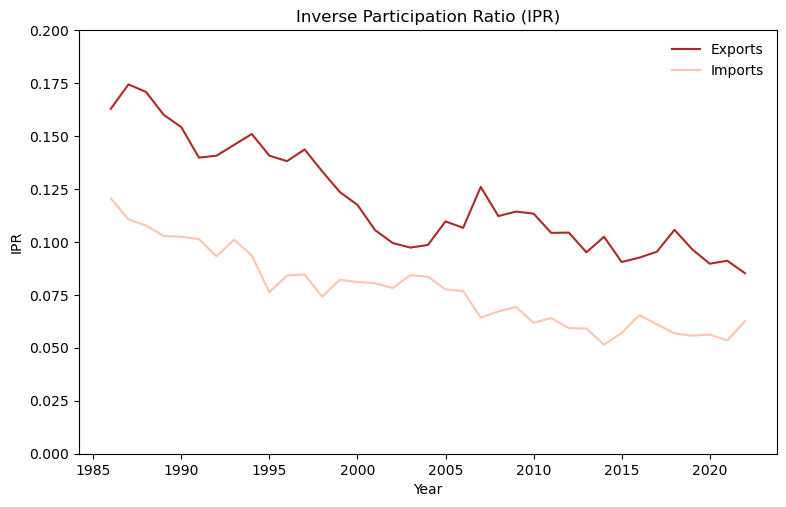

In [14]:

# Load page_Rank for tonnes EXPORTS & imports
page_rank= pd.read_csv(f'/home/ariadna/Food_trade/Data/intermediate/IPR/pr_w_exports_{unit_save}_0_85.csv',index_col=0)
page_rank_imp= pd.read_csv(f'/home/ariadna/Food_trade/Data/intermediate/IPR/pr_w_imports_{unit_save}_0_85.csv',index_col=0)

import matplotlib.pyplot as plt
av_countries=set(data_trade_filt.destin_country_ISO.unique()).union(set(data_trade_og.origin_country_ISO.unique()))
av_countries=sorted([*av_countries])

all_eig= pd.DataFrame(np.zeros((len(av_countries),len(year_list))),index=list(av_countries),columns=year_list)
all_eig_imp = pd.DataFrame(np.zeros((len(av_countries),len(year_list))),index=list(av_countries),columns=year_list)
for y in year_list:
    #exports
    year_df=page_rank.loc[page_rank.year==y,:]
    year_df.loc[:,'country_code']= year_df.country_code.str.split('_').str[1]
    eig_df_ag=year_df.groupby('country_code',as_index=False).page_rank.sum().set_index('country_code')
    all_eig.loc[eig_df_ag.index,y]=eig_df_ag['page_rank'] 
    # imports
    year_df_imp=page_rank_imp.loc[page_rank_imp.year==y,:]
    year_df_imp.loc[:,'country_code']= year_df_imp.country_code.str.split('_').str[1]
    eig_df_ag_imp=year_df_imp.groupby('country_code',as_index=False).page_rank.sum().set_index('country_code')
    all_eig_imp.loc[eig_df_ag_imp.index,y]=eig_df_ag_imp['page_rank'] 

all_eig, all_eig_imp

colors= ['#FCC4AD','#b32626']


# ESTIMATE IPR
ipr_exp = all_eig.apply(lambda x: np.sum(x**4)/(np.sum(x**2)**2),axis=0)
ipr_imp= all_eig_imp.apply(lambda x: np.sum(x**4)/(np.sum(x**2)**2),axis=0)

fig, ax = plt.subplots(figsize=(9,5.5))
ax.plot(ipr_exp.index, ipr_exp,color=colors[1])
ax.plot(ipr_imp.index, ipr_imp,color=colors[0])
ax.set_ylabel('IPR')
ax.set_xlabel('Year')
plt.ylim(0,0.2)
plt.legend(['Exports','Imports'],loc='upper right',frameon=False)
ax.set_title(f'Inverse Participation Ratio (IPR)')
fig.savefig(f'/home/ariadna/Food_trade/Plots/2023/IPR_2directions_{unit_save}_0_85_{save_suffix}.pdf', bbox_inches='tight')

# Explore alphas and weights

/tmp/ipykernel_13812/768840264.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['country_code']= year_df.country_code.str.split('_').str[1]
/tmp/ipykernel_13812/768840264.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['country_code']= year_df.country_code.str.split('_').str[1]
/tmp/ipykernel_13812/768840264.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

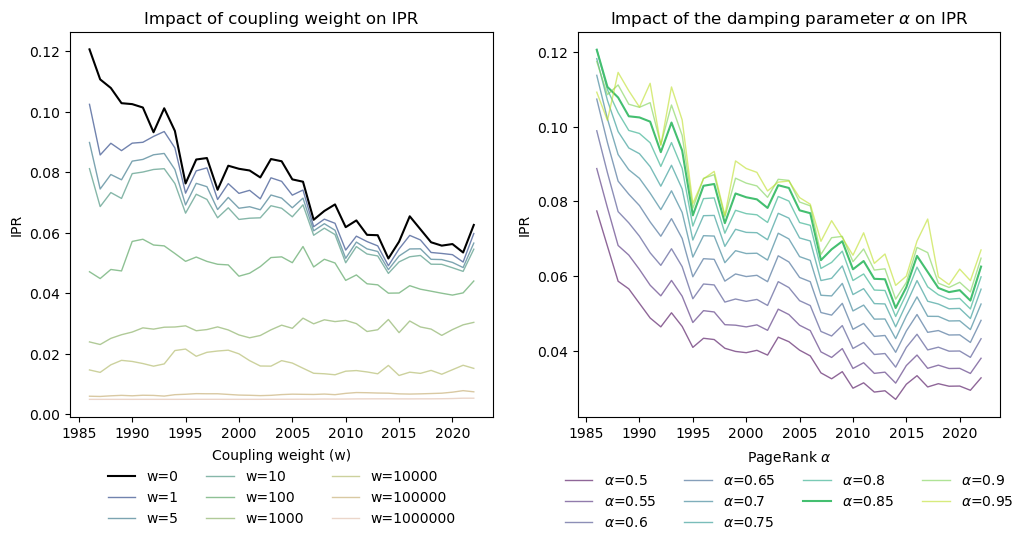

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Explore weights
alpha= 0.85
av_countries=set(data_trade_filt.destin_country_ISO.unique()).union(set(data_trade_og.origin_country_ISO.unique()))
av_countries=sorted([*av_countries])
palette = sns.color_palette(palette='gist_earth',as_cmap=True)#gist_earth # Spectral

for w,weight in enumerate(weight_list):
    page_rank= pd.read_csv(f'../Data/intermediate/IPR/pr_w_imports_doll_{int(weight)}_{int(100*alpha)}.csv',index_col=0)

    all_eig= pd.DataFrame(np.zeros((len(av_countries),len(year_list))),index=list(av_countries),columns=year_list)
    for y in year_list:
        year_df=page_rank.loc[page_rank.year==y,:]
        year_df['country_code']= year_df.country_code.str.split('_').str[1]
        eig_df_ag=year_df.groupby('country_code',as_index=False).page_rank.sum().set_index('country_code')
        all_eig.loc[eig_df_ag.index,y]=eig_df_ag['page_rank'] 
    all_eig

    if weight==0:
        width= 1.5
        transp=1
    else: 
        width=1
        transp=0.6

    # IPR each year using continuous palette
    ipr = all_eig.apply(lambda x: np.sum(x**4)/(np.sum(x**2)**2),axis=0)
    ax[0].plot(ipr.index, ipr,label=f'w={int(weight)}',color=palette(w/len(weight_list)),linewidth=width,alpha=transp)
    ax[0].set_ylabel('IPR')

ax[0].legend( ncol= 3, loc='upper center', bbox_to_anchor=( 0.5,-0.05), title='Coupling weight (w)', frameon=False)
ax[0].set_title('Impact of coupling weight on IPR')

# Different alphas
weight=0
alpha_list=alpha_list
palette = sns.color_palette(palette='viridis',as_cmap=True)#gist_earth # Spectral

for a,alpha in enumerate([int(100*alpha) for alpha in alpha_list]):
    page_rank= pd.read_csv(f'../Data/intermediate/IPR/pr_w_imports_doll_{int(weight)}_{alpha}.csv',index_col=0)

    all_eig= pd.DataFrame(np.zeros((len(av_countries),len(year_list))),index=list(av_countries),columns=year_list)
    for y in year_list:
        year_df=page_rank.loc[page_rank.year==y,:]
        year_df['country_code']= year_df.country_code.str.split('_').str[1]
        eig_df_ag=year_df.groupby('country_code',as_index=False).page_rank.sum().set_index('country_code')
        all_eig.loc[eig_df_ag.index,y]=eig_df_ag['page_rank'] 
    all_eig

    # IPR each year using continuous palette
    ipr = all_eig.apply(lambda x: np.sum(x**4)/(np.sum(x**2)**2),axis=0)

    if alpha==85:
        width= 1.5
        transp=1
    else: 
        width=1
        transp=0.6

    ax[1].plot(ipr.index, ipr,label=fr'$\alpha$={alpha_list[a]}',linewidth=width,alpha=transp,
            color=palette(a/len(alpha_list)))
    ax[1].set_ylabel('IPR')

    

ax[1].legend( ncol= 4, loc='upper center', bbox_to_anchor=( 0.5,-0.05), title=r'PageRank $\alpha$', frameon=False)
plt.title(r'Impact of the damping parameter $\alpha$ on IPR')

fig.savefig(f'/home/ariadna/Food_trade/Plots/2023/IPR_weights_alpha_imports_{unit_save}_{save_suffix}.pdf', bbox_inches='tight')

# IPR per layers
not in paper for now 

In [ ]:
# Create mapping  DF to include the label of right food group: 
mapping_products = Create_map_product_names('../Data/Data_trade_filt_production.pkl')


In [89]:
pr = pd.read_csv(f'/home/ariadna/Food_trade/Data/intermediate/IPR/pr_w_{direction}_{unit_save}_{weight}_{int(100*alpha)}.csv',index_col=0)
pr

,country_code,page_rank,L1_foodex,year
0,A011X_AUT,0.000101,A011X,1986
1,A011X_AFG,0.000127,A011X,1986
2,A02LR_BLZ,0.000077,A02LR,1986
3,A02LR_AFG,0.000077,A02LR,1986
4,A011X_DNK,0.000263,A011X,1986
...,...,...,...,...
97231,A031E_WAK,0.000063,A031E,2022
97232,A032F_WAK,0.000063,A032F,2022
97233,A036M_WAK,0.000063,A036M,2022
97234,A03GG_WAK,0.000063,A03GG,2022


/tmp/ipykernel_404640/2911256915.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=mapping_products.fg_short[p],marker='o')
/tmp/ipykernel_404640/2911256915.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=mapping_products.fg_short[p],marker='o')


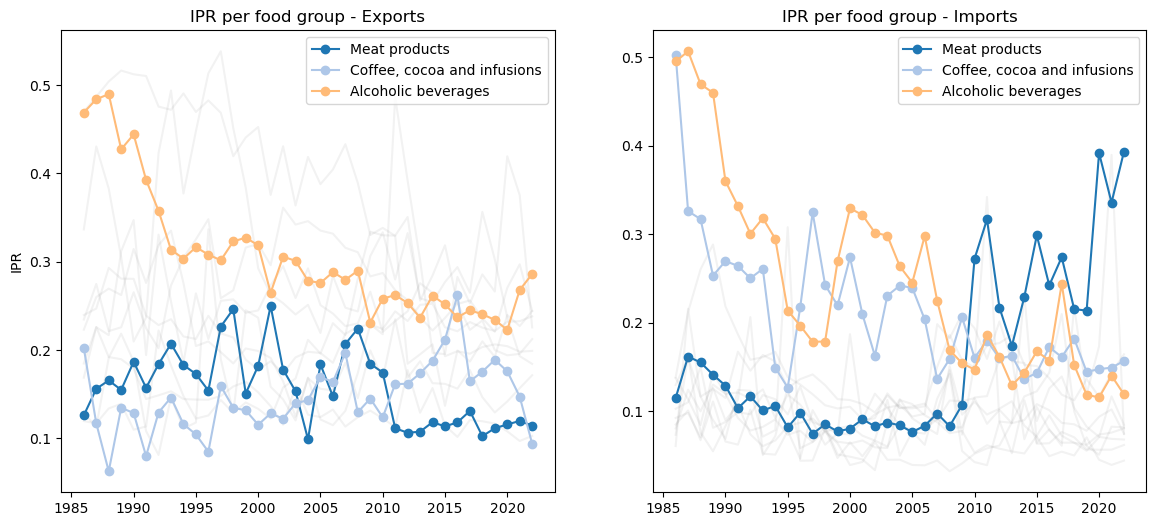

In [148]:

# plot lineplots
# plot temporal evolutiaon 
fig, ax = plt.subplots(1,2,figsize=(14,6))
colors =  plt.cm.tab20(np.linspace(0,1,len(pr.L1_foodex.unique())))
product_highlights= ['A03LZ','A01QR','A03GG']
alpha=0.85
weight=0

# IPR per layers: Exports
direction = 'exports'
pr = pd.read_csv(f'/home/ariadna/Food_trade/Data/intermediate/IPR/pr_w_{direction}_{unit_save}_{weight}_{int(100*alpha)}.csv',index_col=0)

pr['country_code'] = pr.country_code.str.split('_').str[1]

# Estimate IPR  per food group and year
pr_layers= pr.groupby(['year','L1_foodex'],as_index=False).page_rank.apply(lambda x :np.sum(x**4)/np.sum(x**2)**2)
pr_layers.rename(columns={'page_rank':'IPR'},inplace=True)

# Find correlation matrix for dendrogram
corr_matrix_exp, dissimilarity_exp = Correlation_matrix(mapping_products, pr_layers)

# Plot IPR
it = 0 
for p ,product in enumerate(mapping_products.index):

    pr_product = pr_layers.loc[pr_layers.L1_foodex==product,:]
    pr_product = pr_product.sort_values(by='year')
    
    if product in product_highlights:
        ax[0].plot(pr_product.year,pr_product.IPR,color=colors[it],
                label=mapping_products.fg_short[p],marker='o')
        it = it+1
    else:
        ax[0].plot(pr_product.year,pr_product.IPR,color='gray',alpha=0.1)
   
ax[0].legend()
ax[0].set_title('IPR per food group - Exports')
ax[0].set_ylabel('IPR')



# IPR per layers: Imports 
direction = 'imports'
pr = pd.read_csv(f'/home/ariadna/Food_trade/Data/intermediate/IPR/pr_w_{direction}_{unit_save}_{weight}_{int(100*alpha)}.csv',index_col=0)

pr['country_code'] = pr.country_code.str.split('_').str[1]

# Estimate IPR  per food group and year
pr_layers= pr.groupby(['year','L1_foodex'],as_index=False).page_rank.apply(lambda x :np.sum(x**4)/np.sum(x**2)**2)
pr_layers.rename(columns={'page_rank':'IPR'},inplace=True)

# Find correlation matrix for dendrogram
corr_matrix_imp, dissimilarity_imp = Correlation_matrix(mapping_products, pr_layers)

# Plot IPR
it = 0 
for p ,product in enumerate(mapping_products.index):

    pr_product = pr_layers.loc[pr_layers.L1_foodex==product,:]
    pr_product = pr_product.sort_values(by='year')
    
    if product in product_highlights:
        ax[1].plot(pr_product.year,pr_product.IPR,color=colors[it],
                label=mapping_products.fg_short[p],marker='o')
        it = it+1
    else:
        ax[1].plot(pr_product.year,pr_product.IPR,color='gray',alpha=0.1)
    
ax[1].legend()
ax[1].set_title('IPR per food group - Imports')
  
plt.savefig(f'/home/ariadna/Food_trade/Plots/2023/IPR_per_foodgroup_{direction}_{unit_save}_{weight}_{int(100*alpha)}_{save_suffix}.pdf', bbox_inches='tight')

## IPR clusters

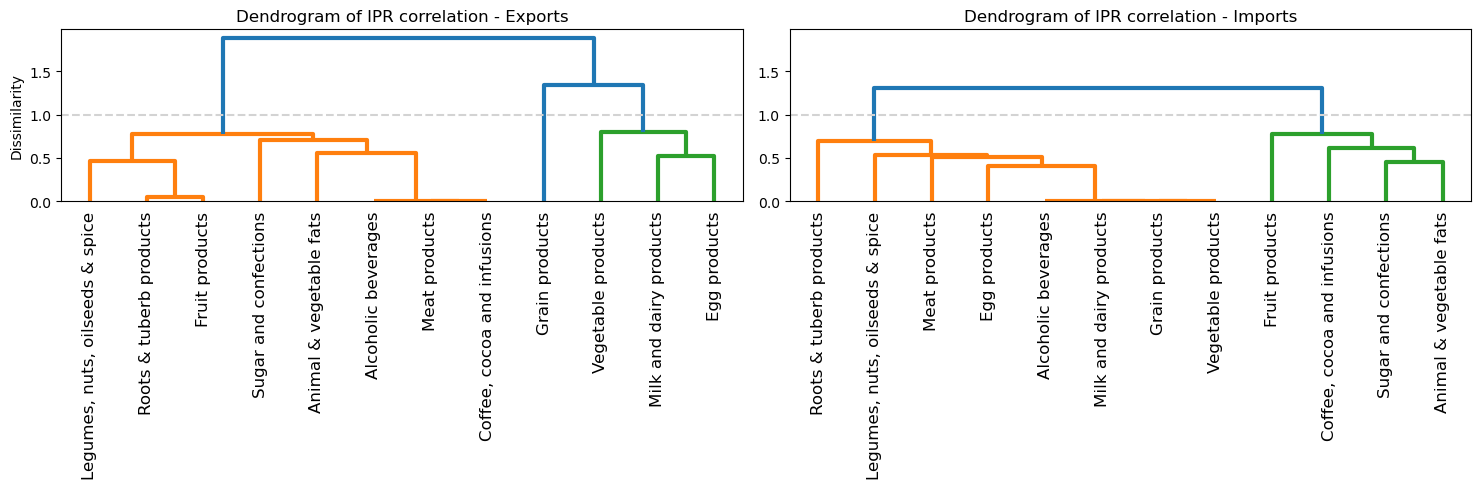

In [155]:
# Correlation between IPR time series
#define combinations of products in foodex

fig, ax = plt.subplots(1,2,figsize=(15, 5))
threshold=1
# ward dendogram: Exports
Z = linkage(dissimilarity_exp, 'ward')
map_labels= corr_matrix_exp.columns.map(mapping_products.fg_short)
dn = dendrogram(Z,labels=map_labels,leaf_rotation=90,ax=ax[0], color_threshold=threshold)
plt.setp(ax[0].collections,linewidth=3,)
ax[0].axhline(y=threshold, color='lightgray', linestyle='--')
ax[0].set_ylabel('Dissimilarity')
ax[0].set_title('Dendrogram of IPR correlation - Exports')

# ward dendogram: Imports
Z = linkage(dissimilarity_imp, 'ward')
map_labels= corr_matrix_imp.columns.map(mapping_products.fg_short)
dn = dendrogram(Z,labels=map_labels,leaf_rotation=90,ax=ax[1], color_threshold=threshold)
plt.setp(ax[1].collections,linewidth=3)
ax[1].axhline(y=threshold, color='lightgray', linestyle='--')
ax[1].set_title('Dendrogram of IPR correlation - Imports')
plt.tight_layout()
ax[1].set_ylim(0,max(ax[0].get_ylim()[1],ax[1].get_ylim()[1]))
fig.savefig('/home/ariadna/Food_trade/Plots/2023/dendogram_IPR_groups.pdf',bbox_inches='tight')